In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [2]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [3]:
df['date_time'] = pd.to_datetime(df['date_time'])
df = df.set_index('date_time')
df = df.drop(['holiday', 'weather_description'], axis=1)
df = pd.get_dummies(df, columns=['weather_main'], prefix='weather')
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,weather_Clear,weather_Clouds,weather_Drizzle,weather_Fog,weather_Haze,weather_Mist,weather_Rain,weather_Smoke,weather_Snow,weather_Squall,weather_Thunderstorm,hour,day_of_week
date_time,,,,,,,,,,,,,,,,,,
2012-10-02 09:00:00,288.28,0.0,0.0,40,5545,False,True,False,False,False,False,False,False,False,False,False,9,1
2012-10-02 10:00:00,289.36,0.0,0.0,75,4516,False,True,False,False,False,False,False,False,False,False,False,10,1
2012-10-02 11:00:00,289.58,0.0,0.0,90,4767,False,True,False,False,False,False,False,False,False,False,False,11,1
2012-10-02 12:00:00,290.13,0.0,0.0,90,5026,False,True,False,False,False,False,False,False,False,False,False,12,1
2012-10-02 13:00:00,291.14,0.0,0.0,75,4918,False,True,False,False,False,False,False,False,False,False,False,13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,283.45,0.0,0.0,75,3543,False,True,False,False,False,False,False,False,False,False,False,19,6
2018-09-30 20:00:00,282.76,0.0,0.0,90,2781,False,True,False,False,False,False,False,False,False,False,False,20,6
2018-09-30 21:00:00,282.73,0.0,0.0,90,2159,False,False,False,False,False,False,False,False,False,False,True,21,6


In [5]:
features = df.columns
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

In [6]:
def create_sequences(data, seq_length):
    X = []
    y = []
    traffic_volume_index = 0
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :])
        y.append(data[i, traffic_volume_index])
    return np.array(X), np.array(y)

In [7]:
SEQ_LENGTH = 48
X, y = create_sequences(scaled_data, SEQ_LENGTH)

In [8]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Using a sequence length of {SEQ_LENGTH} hours.")
print(f"New training data shape: {X_train.shape}")

Using a sequence length of 48 hours.
New training data shape: (38524, 48, 18)


In [9]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 100)           47600     
                                                                 
 dropout (Dropout)           (None, 48, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 133101 (519.93 KB)
Trainable params: 133

In [10]:
history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)
print("Enhanced model training finished.")

Epoch 1/25

542/542 [==============================] - 67s 108ms/step - loss: 0.0080 - val_loss: 7.3445e-04
Epoch 2/25
542/542 [==============================] - 51s 94ms/step - loss: 0.0016 - val_loss: 3.1686e-04
Epoch 3/25
542/542 [==============================] - 49s 91ms/step - loss: 8.3443e-04 - val_loss: 1.1197e-04
Epoch 4/25
542/542 [==============================] - 51s 95ms/step - loss: 5.1256e-04 - val_loss: 1.1268e-04
Epoch 5/25
542/542 [==============================] - 51s 95ms/step - loss: 4.1388e-04 - val_loss: 1.1268e-04
Epoch 6/25
542/542 [==============================] - 51s 95ms/step - loss: 4.0325e-04 - val_loss: 8.2639e-05
Epoch 7/25
542/542 [==============================] - 52s 97ms/step - loss: 4.0526e-04 - val_loss: 1.0711e-04
Epoch 8/25
542/542 [==============================] - 50s 91ms/step - loss: 3.7170e-04 - val_loss: 1.9906e-04
Epoch 9/25
542/542 [==============================] - 51s 94ms/step - loss: 3.6091e-04 - val_loss: 4.3226e-04
Epoch 10/25
542/

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

test_predictions_scaled = model.predict(X_test)

traffic_volume_index = 0
n_features = scaled_data.shape[1]

301/301 [==============================] - 8s 21ms/step


In [12]:
dummy_predictions = np.zeros((len(test_predictions_scaled), n_features))
dummy_actuals = np.zeros((len(y_test), n_features))

dummy_predictions[:, traffic_volume_index] = test_predictions_scaled.ravel()
dummy_actuals[:, traffic_volume_index] = y_test.ravel()

real_predictions = scaler.inverse_transform(dummy_predictions)[:, traffic_volume_index]
real_actuals = scaler.inverse_transform(dummy_actuals)[:, traffic_volume_index]

mae = mean_absolute_error(real_actuals, real_predictions)
rmse = np.sqrt(mean_squared_error(real_actuals, real_predictions))
r2 = r2_score(real_actuals, real_predictions)

In [13]:
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2 Score): {r2:.4f}")

Mean Absolute Error (MAE): 1.48
Root Mean Squared Error (RMSE): 1.88
R-squared (R2 Score): 0.9815


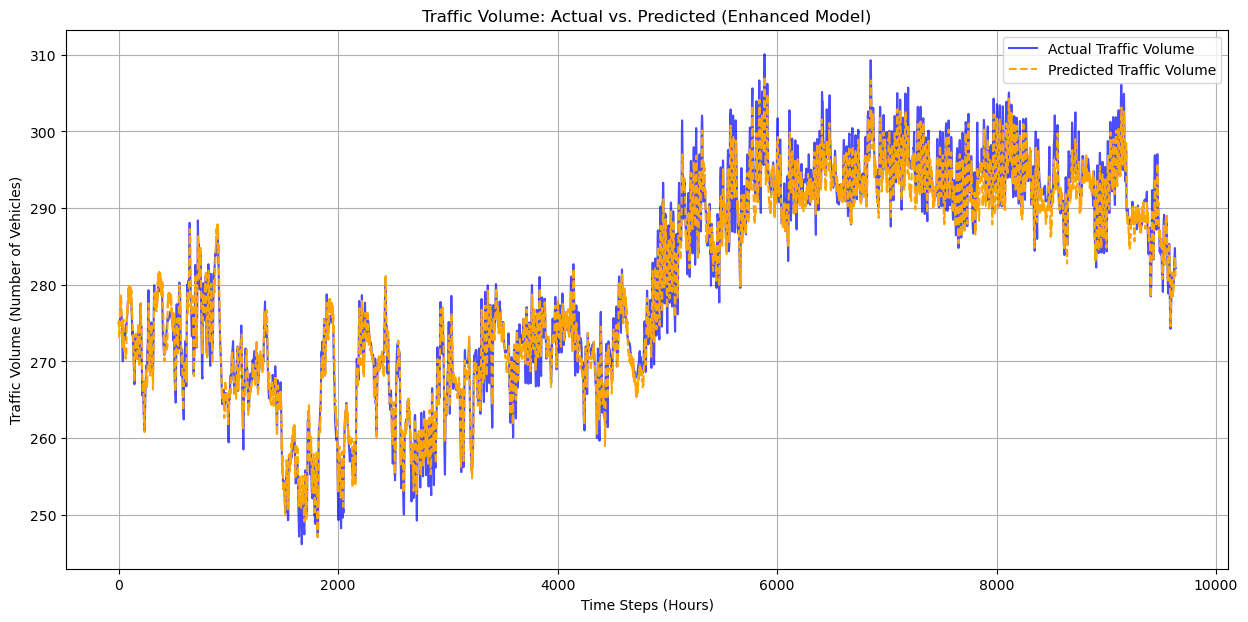

In [14]:
plt.figure(figsize=(15, 7))
plt.plot(real_actuals, label='Actual Traffic Volume', color='blue', alpha=0.7)
plt.plot(real_predictions, label='Predicted Traffic Volume', color='orange', linestyle='--')
plt.title('Traffic Volume: Actual vs. Predicted (Enhanced Model)')
plt.xlabel('Time Steps (Hours)')
plt.ylabel('Traffic Volume (Number of Vehicles)')
plt.legend()
plt.grid(True)
plt.show()